# TwoSentenceHorror Generation using Transformer Model
A lightweight Transformer-based language model trained to generate short two-sentence horror stories with coherent setup and twist.

- Dataset: TinyStories from Microsoft Research & custom synthetic data generated by myself.
- Model: 8-layer decoder-only Transformer (~16.3M parameters)
- Framework: PyTorch
- Interface: Gradio web app for story generation

Key Challenge: Fine-tuning loss refused to go down with original dataset from Reddit. Improved output with a synthetically generated dataset using `gpt-4o-mini`

## Part 1: Setup and Dataset Loading

In [ ]:
!pip install tokenizers pandas matplotlib gradio

In [ ]:
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt

--2025-11-25 17:14:51--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt
Resolving huggingface.co (huggingface.co)... 3.170.185.14, 3.170.185.33, 3.170.185.25, ...
Connecting to huggingface.co (huggingface.co)|3.170.185.14|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/645e8da96320b0efe40ade7a/02e40cc51c59a4bc6c51bd7bc9acda4316e208745be060558eaf500cd14e9f96?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27TinyStoriesV2-GPT4-train.txt%3B+filename%3D%22TinyStoriesV2-GPT4-train.txt%22%3B&response-content-type=text%2Fplain&Expires=1764094491&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzY0MDk0NDkxfX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjQ1ZThkYTk2MzIwYjBlZmU0MGFkZTdhLzAyZTQwY2M1MWM1OWE0YmM2YzUxYmQ3YmM5YWNkYTQzMTZlMjA4NzQ1YmUwNjA1NThlYWY1MDBjZDE0ZTlmOTZcXD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
import math
import re
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.normalizers import NFKC
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from datasets import load_dataset

## Part 2: Tokenizer Training and Dataset Tokenization

In [ ]:
tokenizer = Tokenizer(BPE(unk_token="<UNK>"))
tokenizer.pre_tokenizer = ByteLevel()
tokenizer.normalizer = NFKC()
trainer = BpeTrainer(vocab_size=20000, special_tokens=["<PAD>", "<BOS>", "<EOS>", "<UNK>"], min_frequency=3)

def load_tinystories_simple(file_path, max_stories=50000):
    stories = []
    current = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith('<|endoftext|>'):
                if current:
                    stories.append(' '.join(current))
                    if len(stories) >= max_stories:
                        break
                current = []
            elif line.strip():
                current.append(line.strip())
    return stories

tiny_stories = load_tinystories_simple('TinyStoriesV2-GPT4-train.txt', max_stories=50000)

synthetic_ds = load_dataset("sarthakmasta/TwoSentenceHorrorSynthetic")

synthetic_stories = []
current_story = []
for item in synthetic_ds['train']:
    text = item['text'].strip()
    if text == '<|endoftext|>':
        if current_story:
            story = ' '.join(current_story)
            synthetic_stories.append(story)
            current_story = []
    elif text:
        current_story.append(text)

print(len(synthetic_stories))

combined_corpus = tiny_stories + synthetic_stories

print(len(combined_corpus))

tokenizer.train_from_iterator(combined_corpus, trainer=trainer)
tokenizer.decoder = ByteLevelDecoder()

tokenizer.save("tokenizer.json")
print("Done")

crypt = tokenizer.encode("There was a mysterious ghost in my room.")
print(crypt.tokens)
print(crypt.ids)

PAD_TOKEN = tokenizer.token_to_id("<PAD>")
BOS_TOKEN = tokenizer.token_to_id("<BOS>")
EOS_TOKEN = tokenizer.token_to_id("<EOS>")
VOCAB_SIZE = tokenizer.get_vocab_size()

print(VOCAB_SIZE)
print(f"PAD: {PAD_TOKEN}, BOS: {BOS_TOKEN}, EOS: {EOS_TOKEN}")

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

synthetic_horror_50k.txt: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

50000
100000
Done
['ĠThere', 'Ġwas', 'Ġa', 'Ġmysterious', 'Ġghost', 'Ġin', 'Ġmy', 'Ġroom', '.']
[1452, 129, 102, 2437, 1891, 149, 428, 465, 15]
17415
PAD: 0, BOS: 1, EOS: 2


In [ ]:
def tokenize_story(story):
    encoded = tokenizer.encode(story)
    return [BOS_TOKEN] + encoded.ids + [EOS_TOKEN]

MAX_LENGTH = 50
MIN_LENGTH = 24

synthetic_tokens = []
synthetic_filtered = []
for story in synthetic_stories:
    tokens = tokenize_story(story)
    if MIN_LENGTH <= len(tokens) <= MAX_LENGTH:
        synthetic_tokens.append(tokens)
        synthetic_filtered.append(story)

print(len(synthetic_filtered))

synthetic_df = pd.DataFrame({
    'story': synthetic_filtered,
    'tokens': synthetic_tokens,
    'token_length': [len(t) for t in synthetic_tokens]
})

df = synthetic_df.copy()
print(f"Final: {len(df)}")

49324
Final: 49324


## Part 3: Loading the Data for Training

In [ ]:
class MyDataset(Dataset):
    def __init__(self, tokenized_stories, max_length):
        self.stories = tokenized_stories
        self.max_length = max_length

    def __len__(self):
        return len(self.stories)

    def __getitem__(self, idx):
        tokens = self.stories[idx]

        if len(tokens) < self.max_length:
            tokens = tokens + [PAD_TOKEN] * (self.max_length - len(tokens))

        input_ids = torch.tensor(tokens[:-1], dtype=torch.long)
        target_ids = torch.tensor(tokens[1:], dtype=torch.long)

        return input_ids, target_ids

train_size = int(0.9 * len(df))
train_df = df[:train_size]
val_df = df[train_size:]

train_dataset = MyDataset(train_df['tokens'].tolist(), MAX_LENGTH)
val_dataset = MyDataset(val_df['tokens'].tolist(), MAX_LENGTH)

BATCH_SIZE = 192
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
def load_tinystories(file_path, max_stories=150000):
    stories = []
    current_story = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('<|endoftext|>'):
                if current_story:
                    stories.append(' '.join(current_story))
                    if len(stories) >= max_stories:
                        break
                current_story = []
            elif line:
                current_story.append(line)
    return stories

tiny_train = load_tinystories('TinyStoriesV2-GPT4-train.txt', max_stories=150000)
tiny_val = load_tinystories('TinyStoriesV2-GPT4-valid.txt', max_stories=12000)

PRETRAIN_MAX_LENGTH = 256
tiny_train_tokens = [[BOS_TOKEN] + tokenizer.encode(s).ids + [EOS_TOKEN] for s in tiny_train]
tiny_val_tokens = [[BOS_TOKEN] + tokenizer.encode(s).ids + [EOS_TOKEN] for s in tiny_val]

tiny_train_tokens = [t for t in tiny_train_tokens if len(t) <= PRETRAIN_MAX_LENGTH]
tiny_val_tokens = [t for t in tiny_val_tokens if len(t) <= PRETRAIN_MAX_LENGTH]

pretrain_train_dataset = MyDataset(tiny_train_tokens, PRETRAIN_MAX_LENGTH)
pretrain_val_dataset = MyDataset(tiny_val_tokens, PRETRAIN_MAX_LENGTH)

pretrain_train_loader = DataLoader(pretrain_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
pretrain_val_loader = DataLoader(pretrain_val_dataset, batch_size=BATCH_SIZE)

print(f"Pretrain: {len(pretrain_train_dataset)} train, {len(pretrain_val_dataset)} val")
print(f"Finetune: {len(train_dataset)} train, {len(val_dataset)} val")

Pretrain: 134448 train, 10820 val
Finetune: 44391 train, 4933 val


## Part 4: Defining the Model Architecture

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape

        qkv = self.qkv(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(scores, dim=-1)

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().reshape(batch_size, seq_len, d_model)

        return self.out(out)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.25):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_out = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        return x

class TwoSentenceHorrorModel(nn.Module):
    def __init__(self, vocab_size, d_model=384, num_heads=6, num_layers=6,
                 d_ff=1536, max_seq_len=62, dropout=0.25):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)

        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

        self.max_seq_len = max_seq_len
        self.dropout = nn.Dropout(dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x):
        batch_size, seq_len = x.shape

        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0).to(x.device)

        positions = torch.arange(0, seq_len, dtype=torch.long, device=x.device).unsqueeze(0)
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(positions)
        x = self.dropout(tok_emb + pos_emb)

        for block in self.blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.head(x)

        return logits

model = TwoSentenceHorrorModel(
    vocab_size=VOCAB_SIZE,
    d_model=256,
    num_heads=8,
    num_layers=8,
    d_ff=1024,
    max_seq_len=PRETRAIN_MAX_LENGTH,
    dropout=0.15
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 15,318,023


## Part 5: Training

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

def get_lr(step, warmup_steps, max_steps):
    if step < warmup_steps:
        return step / warmup_steps
    progress = (step - warmup_steps) / (max_steps - warmup_steps)
    return 0.1 + 0.9 * 0.5 * (1.0 + math.cos(math.pi * progress))

In [ ]:
def train_one_epoch(epoch, loader, lr):
    model.train()
    total_loss = 0

    for batch_idx, (input_ids, target_ids) in enumerate(loader):
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)

        step = epoch * len(loader) + batch_idx
        lr_mult = get_lr(step, warmup_steps, max_steps)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr * lr_mult

        optimizer.zero_grad()

        logits = model(input_ids)
        loss = criterion(logits.reshape(-1, VOCAB_SIZE), target_ids.reshape(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Batch {batch_idx+1}/{len(loader)}, Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

    return total_loss/len(loader)


def validate(loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for input_ids, target_ids in loader:
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            logits = model(input_ids)
            loss = criterion(logits.reshape(-1, VOCAB_SIZE), target_ids.reshape(-1))
            total_loss += loss.item()

    return total_loss/len(loader)

In [ ]:
print("Pretraining")

PRETRAIN_EPOCHS = 10
warmup_steps = int(0.1 * len(pretrain_train_loader) * PRETRAIN_EPOCHS)
max_steps = PRETRAIN_EPOCHS * len(pretrain_train_loader)

pretrain_train_losses = []
pretrain_val_losses = []

for epoch in range(PRETRAIN_EPOCHS):
    train_loss = train_one_epoch(epoch, pretrain_train_loader, 3e-4)
    val_loss = validate(pretrain_val_loader)

    pretrain_train_losses.append(train_loss)
    pretrain_val_losses.append(val_loss)

    print(f"Pretrain Epoch {epoch+1}, Train Loss= {train_loss:.4f}, Val Loss= {val_loss:.4f}")

torch.save(model.state_dict(), "pretrained_tinystories.pth")
print("Pretrained model saved!")

new_pos_emb = nn.Embedding(MAX_LENGTH, model.token_embedding.embedding_dim).to(device)
with torch.no_grad():
    new_pos_emb.weight[:MAX_LENGTH] = model.position_embedding.weight[:MAX_LENGTH]
model.position_embedding = new_pos_emb
model.max_seq_len = MAX_LENGTH

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

print("Fine-tuning")

FINETUNE_EPOCHS = 20
warmup_steps = int(0.05 * len(train_loader) * FINETUNE_EPOCHS)
max_steps = FINETUNE_EPOCHS * len(train_loader)

finetune_train_losses = []
finetune_val_losses = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(FINETUNE_EPOCHS):
    train_loss = train_one_epoch(epoch, train_loader, 2e-5)
    val_loss = validate(val_loader)

    finetune_train_losses.append(train_loss)
    finetune_val_losses.append(val_loss)

    print(f"Finetune Epoch {epoch+1}, Train Loss= {train_loss:.4f}, Val Loss= {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_finetuned_horror.pth")
        print("saved")
    else:
        patience_counter += 1
        if patience_counter >= 3:
            print(f"Early stopping at epoch {epoch+1}")
            break

torch.save(model.state_dict(), "final_finetuned_horror.pth")
print("Final model saved.")

Pretraining
  Batch 100/701, Loss: 9.2782, LR: 0.000042
  Batch 200/701, Loss: 8.1279, LR: 0.000085
  Batch 300/701, Loss: 7.1058, LR: 0.000128
  Batch 400/701, Loss: 6.3571, LR: 0.000171
  Batch 500/701, Loss: 5.8268, LR: 0.000214
  Batch 600/701, Loss: 5.4238, LR: 0.000256
  Batch 700/701, Loss: 5.1010, LR: 0.000299
Pretrain Epoch 1, Train Loss= 5.0981, Val Loss= 2.9963
  Batch 100/701, Loss: 2.9547, LR: 0.000300
  Batch 200/701, Loss: 2.8792, LR: 0.000299
  Batch 300/701, Loss: 2.8132, LR: 0.000299
  Batch 400/701, Loss: 2.7570, LR: 0.000297
  Batch 500/701, Loss: 2.7060, LR: 0.000296
  Batch 600/701, Loss: 2.6619, LR: 0.000294
  Batch 700/701, Loss: 2.6212, LR: 0.000292
Pretrain Epoch 2, Train Loss= 2.6208, Val Loss= 2.2694
  Batch 100/701, Loss: 2.3075, LR: 0.000289
  Batch 200/701, Loss: 2.2820, LR: 0.000287
  Batch 300/701, Loss: 2.2601, LR: 0.000284
  Batch 400/701, Loss: 2.2389, LR: 0.000280
  Batch 500/701, Loss: 2.2201, LR: 0.000277
  Batch 600/701, Loss: 2.2011, LR: 0.00027

## Part 6: Plotting the Loss Curves

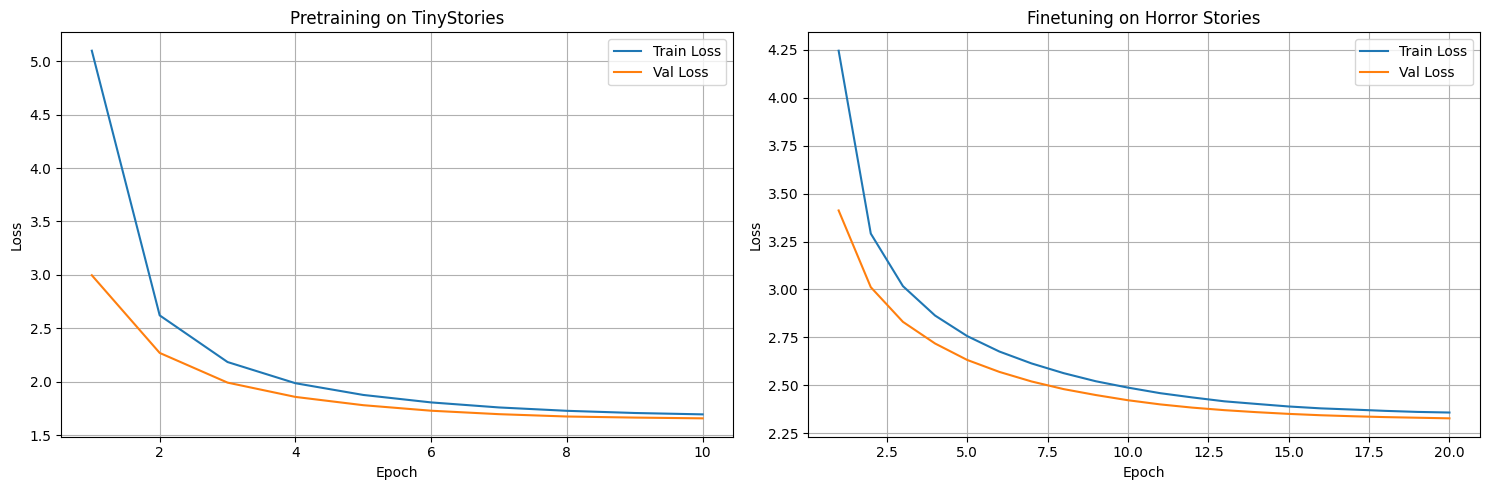


Best pretrain val loss: 1.6571
Best finetune val loss: 2.3272


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, len(pretrain_train_losses)+1), pretrain_train_losses, label='Train Loss')
ax1.plot(range(1, len(pretrain_val_losses)+1), pretrain_val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Pretraining on TinyStories')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, len(finetune_train_losses)+1), finetune_train_losses, label='Train Loss')
ax2.plot(range(1, len(finetune_val_losses)+1), finetune_val_losses, label='Val Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Finetuning on Horror Stories')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest pretrain val loss: {min(pretrain_val_losses):.4f}")
print(f"Best finetune val loss: {min(finetune_val_losses):.4f}")

## Part 7: Testing and Inference

In [ ]:
def generate_story(prompt_sentence=""):
    model.eval()

    if not prompt_sentence.strip():
        first_sentences = [
            "I heard footsteps in the attic last night.",
            "My daughter said there was a monster under her bed.",
            "I woke up to find my front door wide open.",
            "The old woman at the bus stop smiled at me.",
            "I finally managed to fall asleep after hours of insomnia.",
            "My reflection in the mirror looked different today.",
            "The baby monitor made a strange noise.",
            "I went to visit my grandmother's grave.",
            "My phone started ringing at 3 AM.",
            "I found an old photo in the attic.",
            "The power went out during dinner.",
            "I received a text from my dead wife's number.",
            "My son drew a picture of our family.",
            "I heard my mom calling me from downstairs.",
            "The neighborhood kids dared me to enter the abandoned house."
        ]
        prompt_sentence = np.random.choice(first_sentences)

    prompt_ids = tokenizer.encode(prompt_sentence).ids
    tokens = torch.tensor([[BOS_TOKEN] + prompt_ids], dtype=torch.long).to(device)

    temperature = 0.40
    top_k = 30
    top_p = 0.9
    repetition_penalty = 1.2
    max_new_tokens = 55

    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(tokens)
            logits = logits[:, -1, :]

            for token_id in set(tokens[0].tolist()):
                if logits[0, token_id] < 0:
                    logits[0, token_id] *= repetition_penalty
                else:
                    logits[0, token_id] /= repetition_penalty

            logits = logits / temperature

            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')

            top_k_logits, top_k_indices = torch.topk(logits, top_k)
            logits = torch.full_like(logits, float('-inf'))
            logits.scatter_(1, top_k_indices, top_k_logits)

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            if next_token.item() == EOS_TOKEN:
                break
            tokens = torch.cat([tokens, next_token], dim=1)
            if tokens.shape[1] >= MAX_LENGTH - 1:
                break

    generated_ids = tokens.squeeze().tolist()
    cleaned_ids = [t for t in generated_ids if t not in [BOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]
    story = tokenizer.decode(cleaned_ids)

    return story

print("Testing prompted generation:\n")

test_prompts = [
    "I tucked my son into bed.",
    "The doctor gave me the test results.",
    "I heard my wife laughing in the kitchen.",
    "My daughter won't stop staring at the corner.",
    ""
]

for prompt in test_prompts:
    print(f"Prompt: '{prompt}'" if prompt else "Prompt: [Random]")
    story = generate_story(prompt)
    print(f"Story: {story}\n")

Testing prompted generation:

Prompt: 'I tucked my son into bed.'
Story:  I tucked my son into bed. As I turned off the light, he whispered, "Mommy, there's someone under my bed."

Prompt: 'The doctor gave me the test results.'
Story:  The doctor gave me the test results. It was only after I finished that he realized he wasn't alone anymore.

Prompt: 'I heard my wife laughing in the kitchen.'
Story:  I heard my wife laughing in the kitchen. It was only when she turned to look that I remembered her mother had died last year.

Prompt: 'My daughter won't stop staring at the corner.'
Story:  My daughter won't stop staring at the corner. I turned to see her standing behind me, grinning widely.

Prompt: [Random]
Story:  The old woman at the bus stop smiled at me. She had been dead for years, but the man in a face was smiling back at her from the empty street.



In [ ]:
def gradio_gen(first_sentence):
    story = generate_story(first_sentence)

    if first_sentence.strip():
        return story
    else:
        return story


interface = gr.Interface(
    fn=gradio_gen,
    inputs=gr.Textbox(label="First Sentence (optional)", placeholder="Enter the first sentence of your story, or leave blank for a random one...", lines=2),
    outputs=gr.Textbox(label="YOUR Horror Story", lines=5),
    title="Two-Sentence Horror Generator",
    description="Provide a first sentence and the model will complete your horror story with a twist! Leave blank for a random story.",
    examples=[
        ["I tucked my son into bed."],
        ["The doctor gave me the test results."],
        ["I heard my wife laughing in the kitchen."],
        ["My daughter won't stop staring at the corner."],
        ["I woke up to find my front door wide open."],
        ["The old woman at the bus stop smiled at me."],
        ["I received a text from my dead wife's number."],
        [""]
    ],
    allow_flagging="never"
)

interface.launch()

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ebc39fd1c8a1315855.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
